In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import datetime
from openpyxl import load_workbook

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor


from parser.inflation import download_inflation, get_inflation_df
from data_transform.transform_df import transform_df_to_format
from parser.loans_volume_msp import get_loans_volume_msp_df
from parser.dollar import get_dollar_df
from parser.broad_money_supply import get_broad_money_supply
from parser.bal import get_bal_df
from parser.cpi import get_cpi_df
from parser.bal_increase import get_bal_increase_df
from parser.gdp import get_gdp_on_2021_prices_dataframe
from parser.gdp import get_gdp_dataframe_wout_seasons

import dateparser
import matplotlib.dates as mdates

# 1. Выгрузка необходимых данных

## Получим данные по объему кредитов

In [19]:
df = transform_df_to_format(get_loans_volume_msp_df(2019, 2024, spikes_remove = True))
df

,date,month_n,year,Отчетный период,msp_loans_volume
0,2019-01-01,1,2019,Январь 2019 г.,4.028862e+05
1,2019-02-01,2,2019,Февраль 2019 г.,4.208281e+05
2,2019-03-01,3,2019,Март 2019 г.,7.157937e+05
3,2019-04-01,4,2019,Апрель 2019 г.,6.368802e+05
4,2019-05-01,5,2019,Май 2019 г.,5.239981e+05
...,...,...,...,...,...
59,2023-12-01,12,2023,Декабрь 2023 г.,1.437707e+06
60,2024-01-01,1,2024,Январь 2024 г.,1.221420e+06
61,2024-02-01,2,2024,Февраль 2024 г.,1.155451e+06
62,2024-03-01,3,2024,Март 2024 г.,1.636295e+06


In [20]:
list_of_df = [] # список для хранения датафреймов с интересущими нас параметрами

## Выгружаем данные по инфляции и ключевой ставке

In [21]:
start_date = datetime.datetime.strptime("01.01.2019", "%d.%m.%Y")
end_date = datetime.datetime.strptime("01.05.2024", "%d.%m.%Y")
download_inflation(start_date, end_date)
df_inflation = transform_df_to_format(get_inflation_df(start_date, end_date, spikes_remove=True))
df_inflation = df_inflation.reset_index(drop=True)
list_of_df.append(df_inflation)
df_inflation

C:\Users\Дарья\AppData\Local\Programs\Python\Python311\Lib\site-packages\openpyxl\styles\stylesheet.py:241: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,date,"Инфляция, % г/г",month_n,year,Отчетный период,"Ключевая ставка, % годовых"
0,2019-01-01,5.003896,1,2019,Январь 2019 г.,7.750223
1,2019-02-01,5.204505,2,2019,Февраль 2019 г.,7.749576
2,2019-03-01,5.291599,3,2019,Март 2019 г.,7.750160
3,2019-04-01,5.203896,4,2019,Апрель 2019 г.,7.750000
4,2019-05-01,5.103896,5,2019,Май 2019 г.,7.750223
...,...,...,...,...,...,...
59,2023-12-01,7.424505,12,2023,Декабрь 2023 г.,15.988864
60,2024-01-01,7.431599,1,2024,Январь 2024 г.,16.000160
61,2024-02-01,7.693896,2,2024,Февраль 2024 г.,15.999829
62,2024-03-01,7.711599,3,2024,Март 2024 г.,16.000160


## Выгружаем данные о курсе доллара

In [22]:
df_dollar = transform_df_to_format(get_dollar_df(start_date, end_date, spikes_remove=True))
list_of_df.append(df_dollar)
df_dollar

C:\Users\Дарья\AppData\Local\Programs\Python\Python311\Lib\site-packages\openpyxl\styles\stylesheet.py:241: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,date,month_n,year,Отчетный период,curs
0,2019-01-01,1,2019,Январь 2019 г.,66.578136
1,2019-02-01,2,2019,Февраль 2019 г.,65.133831
2,2019-03-01,3,2019,Март 2019 г.,65.703359
3,2019-04-01,4,2019,Апрель 2019 г.,64.668697
4,2019-05-01,5,2019,Май 2019 г.,64.142012
...,...,...,...,...,...
59,2023-12-01,12,2023,Декабрь 2023 г.,91.428288
60,2024-01-01,1,2024,Январь 2024 г.,88.745880
61,2024-02-01,2,2024,Февраль 2024 г.,90.841561
62,2024-03-01,3,2024,Март 2024 г.,92.342735


## Выгружаем данные о широкой денежной массе 

In [23]:
broad_money_supply = transform_df_to_format(get_broad_money_supply(2019, 2024, spikes_remove=True))
list_of_df.append(broad_money_supply)
broad_money_supply

,date,month_n,year,Отчетный период,broad_money
0,2019-01-01,1,2019,Январь 2019 г.,59470.264021
1,2019-02-01,2,2019,Февраль 2019 г.,60419.563228
2,2019-03-01,3,2019,Март 2019 г.,60505.672751
3,2019-04-01,4,2019,Апрель 2019 г.,60172.164021
4,2019-05-01,5,2019,Май 2019 г.,60909.663228
...,...,...,...,...,...
59,2023-12-01,12,2023,Декабрь 2023 г.,110191.059708
60,2024-01-01,1,2024,Январь 2024 г.,111467.964021
61,2024-02-01,2,2024,Февраль 2024 г.,113794.763228
62,2024-03-01,3,2024,Март 2024 г.,116017.032751


## Выгружаем данные о ВВП

In [24]:
gdp_on_2021_prices_df = get_gdp_on_2021_prices_dataframe(spikes_remove=True)
gdp_on_2021_prices_df = gdp_on_2021_prices_df[gdp_on_2021_prices_df['date'] >= start_date]
gdp_on_2021_prices_df = gdp_on_2021_prices_df[gdp_on_2021_prices_df['date'] < end_date]
gdp_on_2021_prices_df = gdp_on_2021_prices_df.drop('date', axis = 1)
gdp_on_2021_prices_df = gdp_on_2021_prices_df.reset_index(drop=True)
gdp_on_2021_prices_df = gdp_on_2021_prices_df.rename(columns={'gdp': 'gdp_on_2021_prices'})
gdp_on_2021_prices_df

C:\Users\Дарья\Documents\pydatan\проект\hub-act-frcst\parser\gdp.py:65: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_df = pd.concat([new_df, pd.DataFrame(


,gdp_on_2021_prices
0,31391.859286
1,29264.877803
2,29227.783858
3,31873.913742
4,31790.264260
...,...
56,35744.794241
57,39336.797588
58,39253.148105
59,35767.669533


In [25]:
gdp_wout_seasons_df = get_gdp_dataframe_wout_seasons()
gdp_wout_seasons_df = gdp_wout_seasons_df[gdp_wout_seasons_df['date'] >= start_date]
gdp_wout_seasons_df = gdp_wout_seasons_df[gdp_wout_seasons_df['date'] < end_date]
gdp_wout_seasons_df = gdp_wout_seasons_df.drop('date', axis = 1)
gdp_wout_seasons_df = gdp_wout_seasons_df.reset_index(drop=True)
gdp_wout_seasons_df = gdp_wout_seasons_df.rename(columns={'gdp': 'gdp_wout_seasons'})
gdp_wout_seasons_df

C:\Users\Дарья\Documents\pydatan\проект\hub-act-frcst\parser\gdp.py:109: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_df = pd.concat([new_df, pd.DataFrame(


,gdp_wout_seasons
0,32614.810098
1,32614.810098
2,32614.810098
3,32725.823537
4,32725.823537
...,...
56,34951.030276
57,35225.308081
58,35225.308081
59,35225.308081


## Выгрузка данных о темпе прироста потребительских цен

In [26]:
bal_increase_df = get_bal_increase_df(spikes_remove=False) # до мая 2024 года, тут тоже не работает True
bal_increase_df = bal_increase_df[bal_increase_df['date'] >= start_date]
bal_increase_df = bal_increase_df[bal_increase_df['date'] < end_date]
bal_increase_df = bal_increase_df.drop('date', axis = 1)
bal_increase_df = bal_increase_df.reset_index(drop=True)
bal_increase_df

,bal_increase
0,0.738837
1,0.326346
2,0.291960
3,0.261887
4,0.361780
...,...
59,0.539416
60,0.509108
61,0.509485
62,0.369283


# Соединяем датафреймы для получения итогового и смотрим корреляцию

In [31]:
df_total = df
for i in list_of_df:
    df_total = pd.merge(df_total, i,  on=['Отчетный период', 'month_n', 'year', 'date'], how='inner')
df_total = pd.concat([df_total, bal_increase_df], axis = 1)
df_total = pd.concat([df_total, gdp_wout_seasons_df], axis = 1)
df_total = pd.concat([df_total, gdp_on_2021_prices_df], axis = 1)
df_total['gdp_wout_seasons'] = df_total['gdp_wout_seasons'].fillna(method='ffill')
df_total['gdp_on_2021_prices'] = df_total['gdp_on_2021_prices'].fillna(method='ffill')
df_total

C:\Users\Дарья\AppData\Local\Temp\ipykernel_6840\3469972337.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_total['gdp_wout_seasons'] = df_total['gdp_wout_seasons'].fillna(method='ffill')
C:\Users\Дарья\AppData\Local\Temp\ipykernel_6840\3469972337.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_total['gdp_on_2021_prices'] = df_total['gdp_on_2021_prices'].fillna(method='ffill')


,date,month_n,year,Отчетный период,msp_loans_volume,"Инфляция, % г/г","Ключевая ставка, % годовых",curs,broad_money,bal_increase,gdp_wout_seasons,gdp_on_2021_prices
0,2019-01-01,1,2019,Январь 2019 г.,4.028862e+05,5.003896,7.750223,66.578136,59470.264021,0.738837,32614.810098,31391.859286
1,2019-02-01,2,2019,Февраль 2019 г.,4.208281e+05,5.204505,7.749576,65.133831,60419.563228,0.326346,32614.810098,29264.877803
2,2019-03-01,3,2019,Март 2019 г.,7.157937e+05,5.291599,7.750160,65.703359,60505.672751,0.291960,32614.810098,29227.783858
3,2019-04-01,4,2019,Апрель 2019 г.,6.368802e+05,5.203896,7.750000,64.668697,60172.164021,0.261887,32725.823537,31873.913742
4,2019-05-01,5,2019,Май 2019 г.,5.239981e+05,5.103896,7.750223,64.142012,60909.663228,0.361780,32725.823537,31790.264260
...,...,...,...,...,...,...,...,...,...,...,...,...
59,2023-12-01,12,2023,Декабрь 2023 г.,1.437707e+06,7.424505,15.988864,91.428288,110191.059708,0.539416,35225.308081,35767.669533
60,2024-01-01,1,2024,Январь 2024 г.,1.221420e+06,7.431599,16.000160,88.745880,111467.964021,0.509108,35575.609534,32325.082178
61,2024-02-01,2,2024,Февраль 2024 г.,1.155451e+06,7.693896,15.999829,90.841561,113794.763228,0.509485,35575.609534,32325.082178
62,2024-03-01,3,2024,Март 2024 г.,1.636295e+06,7.711599,16.000160,92.342735,116017.032751,0.369283,35575.609534,32325.082178


In [32]:
df_total_for_corr = df_total.drop('Отчетный период', axis = 1) # убираем отчетный период, так как данный тип данных мешает рассчету корреляции
df_total_for_corr.corr()

,date,month_n,year,msp_loans_volume,"Инфляция, % г/г","Ключевая ставка, % годовых",curs,broad_money,bal_increase,gdp_wout_seasons,gdp_on_2021_prices
date,1.000000,0.058091,0.982298,0.780323,0.445873,0.578405,0.627849,0.976172,0.126480,0.770701,0.331885
month_n,0.058091,1.000000,-0.129944,0.317559,0.019075,-0.138078,-0.033427,0.004297,-0.124930,0.038295,0.773107
year,0.982298,-0.129944,1.000000,0.715643,0.439264,0.600464,0.629832,0.968726,0.149219,0.758250,0.184472
msp_loans_volume,0.780323,0.317559,0.715643,1.000000,0.178949,0.507180,0.641508,0.810531,0.087231,0.733259,0.405597
"Инфляция, % г/г",0.445873,0.019075,0.439264,0.178949,1.000000,0.428052,-0.198868,0.322842,0.198205,0.211443,0.093159
"Ключевая ставка, % годовых",0.578405,-0.138078,0.600464,0.507180,0.428052,1.000000,0.528418,0.634960,0.444607,0.628381,0.092305
curs,0.627849,-0.033427,0.629832,0.641508,-0.198868,0.528418,1.000000,0.733571,0.258440,0.646875,0.198712
broad_money,0.976172,0.004297,0.968726,0.810531,0.322842,0.634960,0.733571,1.000000,0.125164,0.804984,0.279038
bal_increase,0.126480,-0.124930,0.149219,0.087231,0.198205,0.444607,0.258440,0.125164,1.000000,0.202543,-0.059200
gdp_wout_seasons,0.770701,0.038295,0.758250,0.733259,0.211443,0.628381,0.646875,0.804984,0.202543,1.000000,0.456027


Оставляем параметры, которые показали хорошую корреляцию с объемом кредитов

In [33]:
df_total = df_total[['Отчетный период','month_n', 'msp_loans_volume', 'Инфляция, % г/г', 'Ключевая ставка, % годовых', 'year', 'curs', 'broad_money', 'gdp_wout_seasons']]
df_total.head()

,Отчетный период,month_n,msp_loans_volume,"Инфляция, % г/г","Ключевая ставка, % годовых",year,curs,broad_money,gdp_wout_seasons
0,Январь 2019 г.,1,402886.167196,5.003896,7.750223,2019,66.578136,59470.264021,32614.810098
1,Февраль 2019 г.,2,420828.091005,5.204505,7.749576,2019,65.133831,60419.563228,32614.810098
2,Март 2019 г.,3,715793.741799,5.291599,7.750160,2019,65.703359,60505.672751,32614.810098
3,Апрель 2019 г.,4,636880.167196,5.203896,7.750000,2019,64.668697,60172.164021,32725.823537
4,Май 2019 г.,5,523998.091005,5.103896,7.750223,2019,64.142012,60909.663228,32725.823537


# Подготовка данных и обучение модели

## Подготовка данных 

In [34]:
# Извлекаем год из столбца "Отчетный период"
df_total['data'] = df['Отчетный период'].str.extract(r'(\d{4})').astype(int)

# Формируем новый столбец "Дата" в формате YYYY-MM
df_total['data'] = df_total['data'].astype(str) + '-' + df_total['month_n'].astype(str)
df_total['data'] = pd.to_datetime(df_total['data'])

# Удаляем временные столбцы
df_total = df_total.drop('Отчетный период', axis=1)
df_total

C:\Users\Дарья\AppData\Local\Temp\ipykernel_6840\1437758174.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_total['data'] = df['Отчетный период'].str.extract(r'(\d{4})').astype(int)
C:\Users\Дарья\AppData\Local\Temp\ipykernel_6840\1437758174.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_total['data'] = df_total['data'].astype(str) + '-' + df_total['month_n'].astype(str)
C:\Users\Дарья\AppData\Local\Temp\ipykernel_6840\1437758174.py:6: SettingWithCopyWarning: 
A value is trying to be set on a

,month_n,msp_loans_volume,"Инфляция, % г/г","Ключевая ставка, % годовых",year,curs,broad_money,gdp_wout_seasons,data
0,1,4.028862e+05,5.003896,7.750223,2019,66.578136,59470.264021,32614.810098,2019-01-01
1,2,4.208281e+05,5.204505,7.749576,2019,65.133831,60419.563228,32614.810098,2019-02-01
2,3,7.157937e+05,5.291599,7.750160,2019,65.703359,60505.672751,32614.810098,2019-03-01
3,4,6.368802e+05,5.203896,7.750000,2019,64.668697,60172.164021,32725.823537,2019-04-01
4,5,5.239981e+05,5.103896,7.750223,2019,64.142012,60909.663228,32725.823537,2019-05-01
...,...,...,...,...,...,...,...,...,...
59,12,1.437707e+06,7.424505,15.988864,2023,91.428288,110191.059708,35225.308081,2023-12-01
60,1,1.221420e+06,7.431599,16.000160,2024,88.745880,111467.964021,35575.609534,2024-01-01
61,2,1.155451e+06,7.693896,15.999829,2024,90.841561,113794.763228,35575.609534,2024-02-01
62,3,1.636295e+06,7.711599,16.000160,2024,92.342735,116017.032751,35575.609534,2024-03-01


## Разделение данных на тестовые, тренировочные и валидационные

In [64]:
split_data = '2023-04'
trn_val = df_total[df_total['data']<split_data]
trn, val = train_test_split(trn_val, test_size=0.2, random_state=47)
test = df_total[df_total['data']>=split_data]

# тренировочные данные
Xtrn = trn.drop(['data', 'msp_loans_volume'], axis = 1)
Ytrn = trn['msp_loans_volume']

# данные для вывода (будет позднее) фактических значений 
Y_trn_val = trn_val['msp_loans_volume']

# тренировочные данные
Xtest = test.drop(['data', 'msp_loans_volume'], axis = 1)
Ytest = test['msp_loans_volume']

# валидационные данные 
Xval = val.drop(['data', 'msp_loans_volume'], axis = 1)
Yval = val['msp_loans_volume']

print(trn.shape, val.shape, test.shape)

(40, 9) (11, 9) (13, 9)


## Создание и обучение модели

In [66]:
regressor = CatBoostRegressor(iterations=1000, depth=2, learning_rate=0.01)
regressor.fit(Xtrn, Ytrn, verbose=False)

# Предсказание и оценка
predictions = regressor.predict(Xtest)
print(predictions)

[ 940096.82963693 1099676.38553463 1142536.47212715 1119519.05115659
 1137716.54692849 1190765.31006696 1218270.2574065  1218784.89440243
 1330761.19142439 1006452.738875   1013318.85532214 1228988.20984171
 1165782.61971971]


In [67]:
Ytest # можно сравнить с тем, что получилось выше

51    1.113117e+06
52    1.143265e+06
53    1.487425e+06
54    1.248651e+06
55    1.475003e+06
56    1.687433e+06
57    1.684164e+06
58    1.318051e+06
59    1.437707e+06
60    1.221420e+06
61    1.155451e+06
62    1.636295e+06
63    1.541567e+06
Name: msp_loans_volume, dtype: float64

## Рассчет средней абсолютной процентная ошибки (MAPE) 

Рассчет средней абсолютной процентная ошибки (MAPE) - средняя разница между прогнозируемым значением и фактическим значением

In [68]:
def mape(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    actual_safe = np.where(actual == 0, 1e-10, actual)
    return np.mean(np.abs((actual - pred) / actual_safe))

mape(Ytest.values, predictions)

0.17460614170553995

## Визуальный анализ

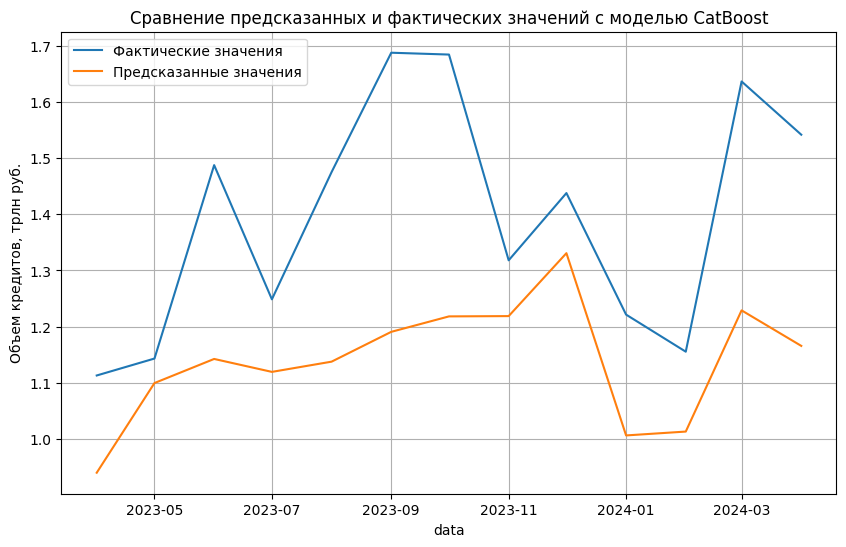

In [69]:
# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(test['data'], Ytest.values/ 1e6, label='Фактические значения')
plt.plot(test['data'], predictions/ 1e6, label='Предсказанные значения')
plt.xlabel('data')
plt.ylabel('Объем кредитов, трлн руб.')
plt.title('Сравнение предсказанных и фактических значений с моделью CatBoost')
plt.legend()
plt.grid(True)
plt.show()

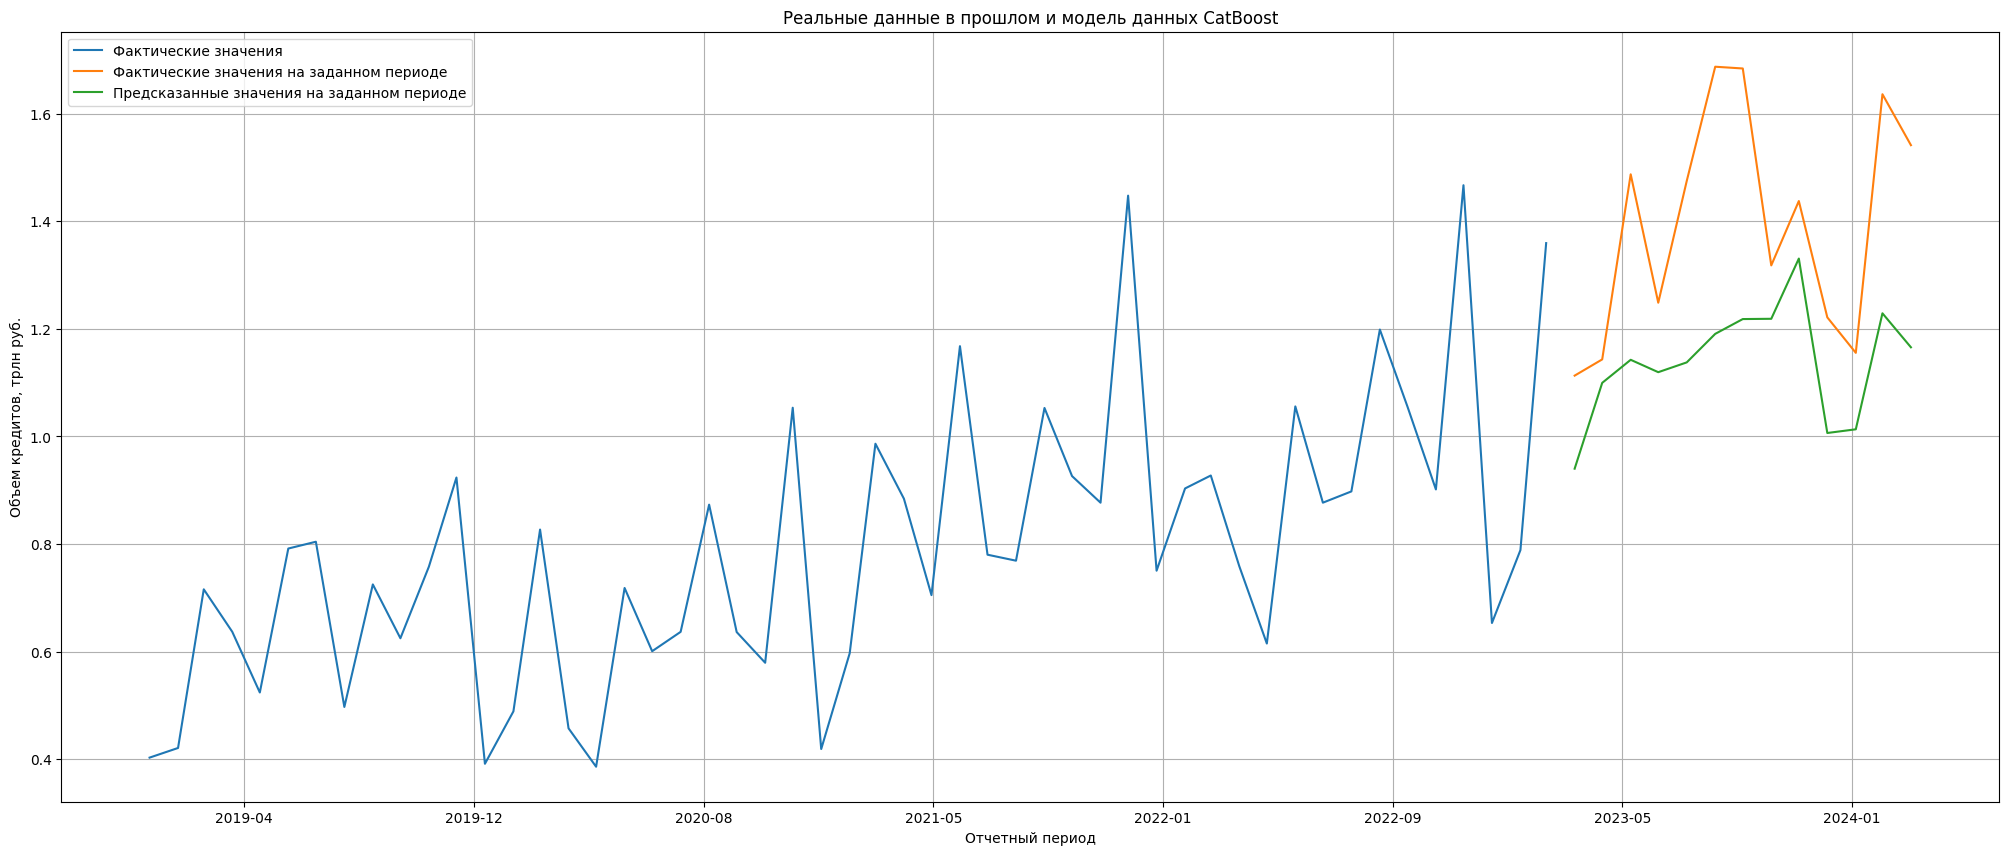

In [70]:
# Построение графика
plt.figure(figsize=(25, 10))
plt.plot(mdates.date2num(trn_val['data']), Y_trn_val.values/ 1e6, label='Фактические значения')
plt.plot(mdates.date2num(test['data']), Ytest.values/ 1e6, label='Фактические значения на заданном периоде')
plt.plot(mdates.date2num(test['data']), predictions/ 1e6, label='Предсказанные значения на заданном периоде')
plt.xlabel('Отчетный период')
plt.ylabel('Объем кредитов, трлн руб.')
plt.title('Реальные данные в прошлом и модель данных CatBoost')
plt.legend()
plt.grid(True)
# Настройка отображения дат на оси X
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # формат даты

plt.show()

# Оптимизация гиперпараметров

In [71]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

mape_scorer = make_scorer(mape, greater_is_better=False)
param_grid = {
    'iterations': [100, 200, 500, 1000],
    'depth': [2, 4, 6],
    'learning_rate': [0.001, 0.01, 0.05, 0.1]
}

# Создание объекта GridSearchCV
grid_search = GridSearchCV(estimator=CatBoostRegressor(verbose=False), 
                           param_grid=param_grid, 
                           cv=3, 
                           scoring=mape_scorer) 

# Запуск поиска по сетке гиперпараметров НА ТРЕНИРОВОЧНЫХ ДАННЫХ
grid_search.fit(Xtrn, Ytrn)

# Вывод лучших гиперпараметров
print("Лучшие параметры:", grid_search.best_params_)

# Создание модели с лучшими гиперпараметрами
best_regressor = grid_search.best_estimator_

# Предсказание и оценка на ВАЛИДАЦИОННЫХ данных
predictions_val = best_regressor.predict(Xval) 
predictions_val

Лучшие параметры: {'depth': 2, 'iterations': 1000, 'learning_rate': 0.05}


array([ 898769.43392295,  792710.23205646, 1003083.52199584,
        936994.99469063,  908283.24268343, 1053072.28613299,
       1066645.29254839,  767732.9629965 ,  512670.4262206 ,
       1011943.33957171,  599878.09568737])

In [72]:
mape(Yval.values, predictions_val)

0.1811612797906097

In [73]:
predictions_opt = best_regressor.predict(Xtest)
mape(Ytest.values, predictions_opt)

0.15988381183550246

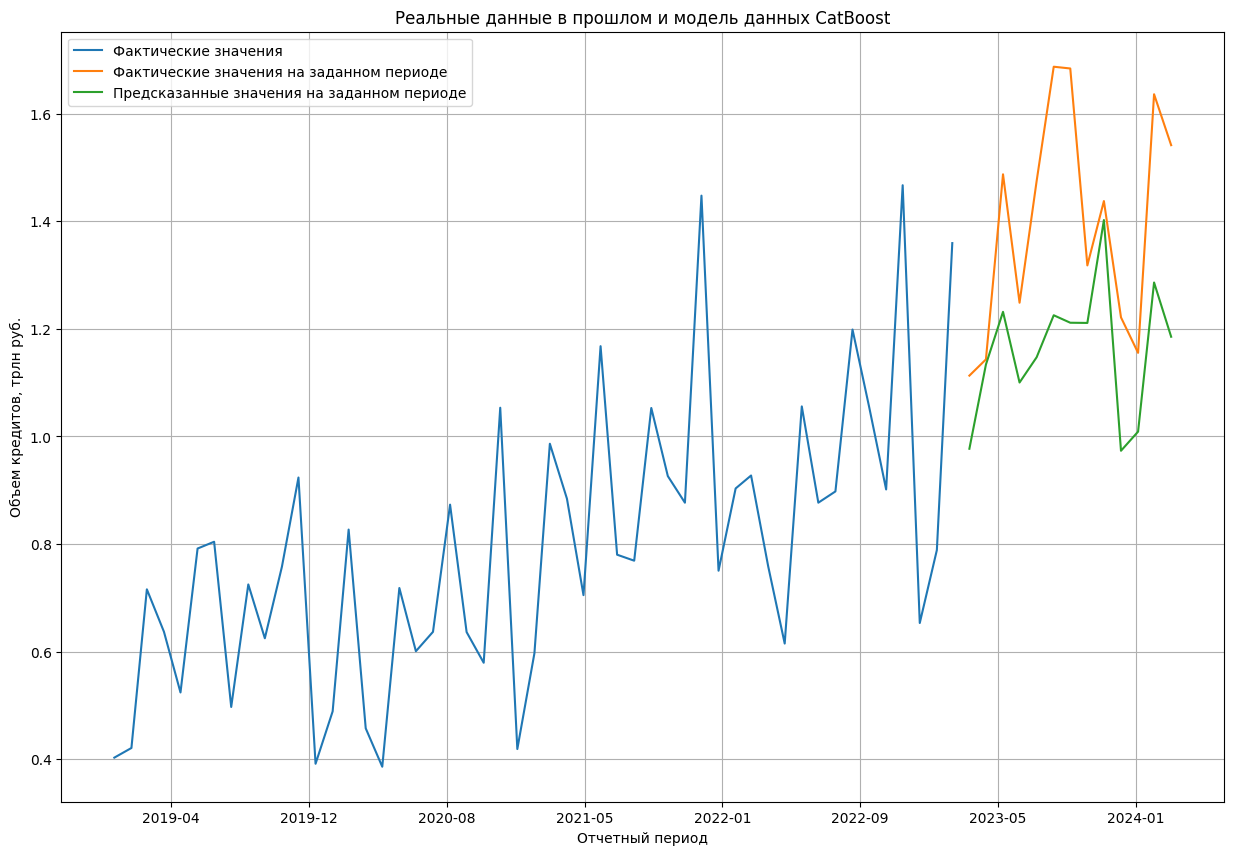

In [74]:
# Построение графика
plt.figure(figsize=(15, 10))
plt.plot(mdates.date2num(trn_val['data']), Y_trn_val.values/ 1e6, label='Фактические значения')
plt.plot(mdates.date2num(test['data']), Ytest.values/ 1e6, label='Фактические значения на заданном периоде')
plt.plot(mdates.date2num(test['data']), predictions_opt/ 1e6, label='Предсказанные значения на заданном периоде')
plt.xlabel('Отчетный период')
plt.ylabel('Объем кредитов, трлн руб.')
plt.title('Реальные данные в прошлом и модель данных CatBoost')
plt.legend()
plt.grid(True)
# Настройка отображения дат на оси X
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # формат даты

plt.show()

# Отбор наилучших признаков

## Алгоритм для отбора и обучения модели

In [75]:
from sklearn.feature_selection import SequentialFeatureSelector

# Создание объекта SequentialFeatureSelector
selector = SequentialFeatureSelector(best_regressor,  # Используем модель с лучшими гиперпараметрами
                                   n_features_to_select='auto',
                                   direction='forward',
                                   scoring=mape_scorer,  # Используем метрику
                                   cv=3) 

# Обучение селектора на ТРЕНИРОВОЧНЫХ данных
selector.fit(Xtrn, Ytrn)

# Получение маски выбранных признаков
selected_features_mask = selector.get_support()

# Вывод названий выбранных признаков
selected_features = Xtrn.columns[selected_features_mask]
print("Выбранные признаки:", selected_features)

# Преобразование данных с использованием выбранных признаков
Xtrn_selected = selector.transform(Xtrn)
Xval_selected = selector.transform(Xval)
Xtest_selected = selector.transform(Xtest) # Преобразование тестовых данных

# Обучение модели с лучшими гиперпараметрами и выбранными признаками на ТРЕНИРОВОЧНЫХ данных
best_regressor.fit(Xtrn_selected, Ytrn, verbose=False)

# Предсказание на ВАЛИДАЦИОННЫХ данных 
predictions_val = best_regressor.predict(Xval_selected)

Выбранные признаки: Index(['month_n', 'year', 'broad_money'], dtype='object')


In [76]:
mape(Yval.values, predictions_val)

0.17139888969436298

In [77]:
predictions_opt_total = best_regressor.predict(Xtest_selected)
mape(Ytest.values, predictions_opt_total)

0.13258132160661396

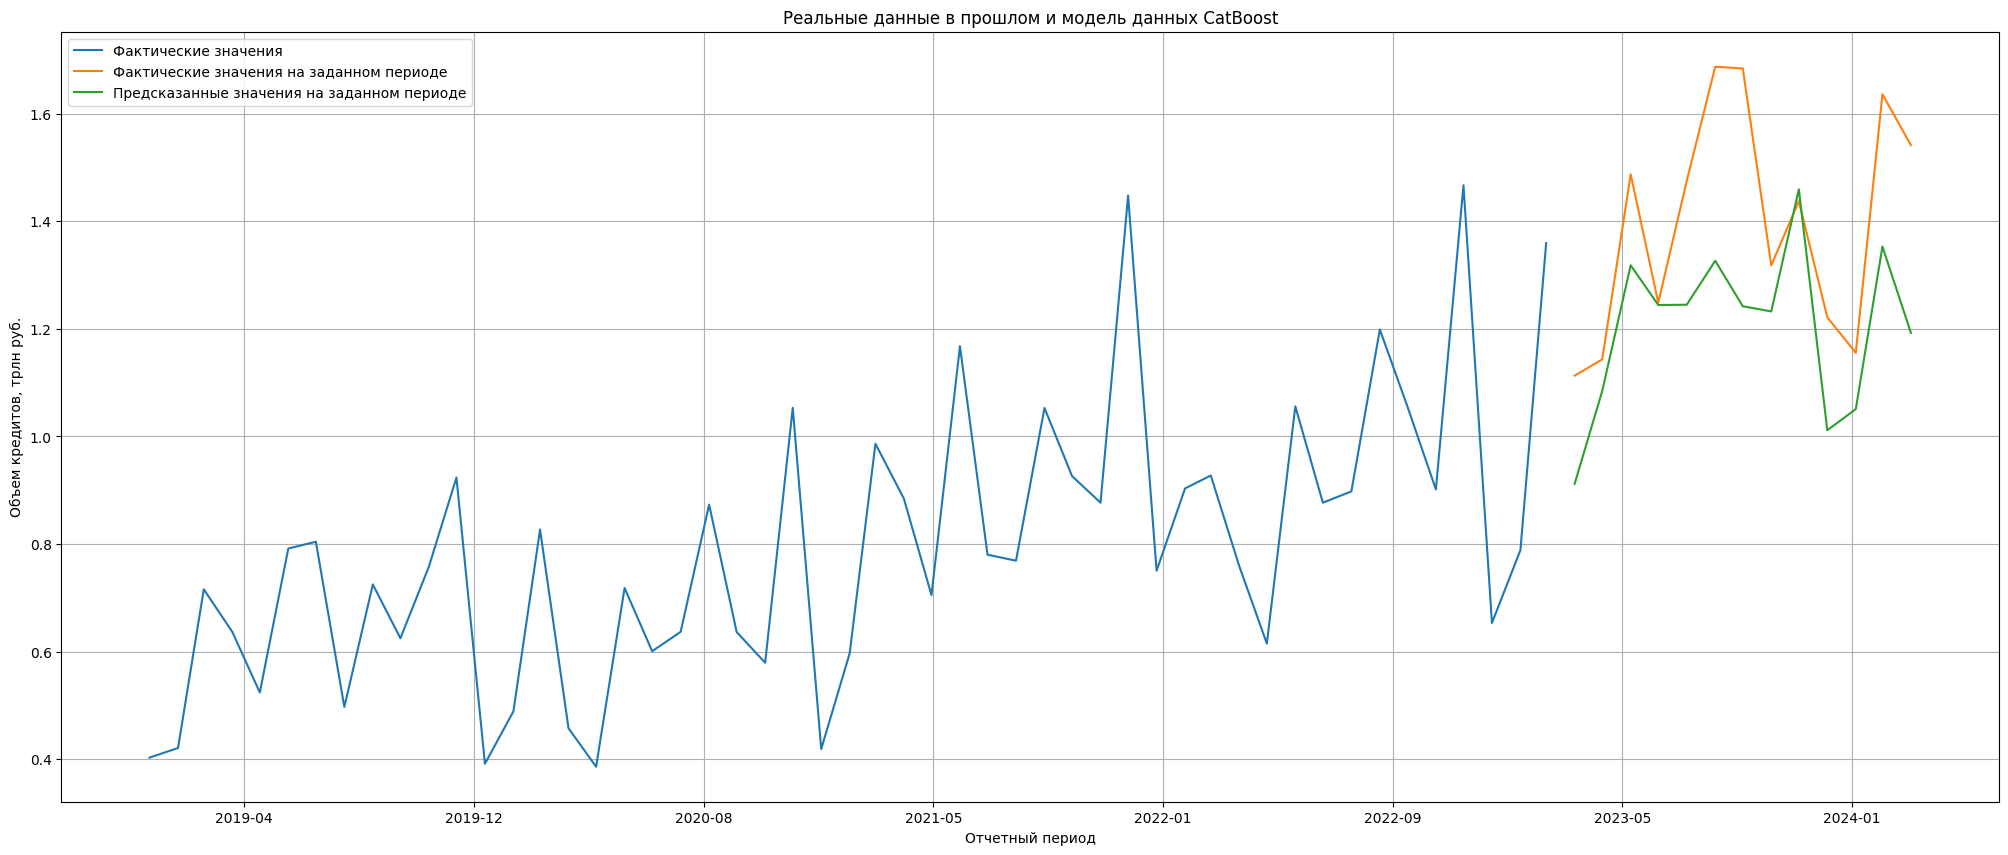

In [78]:
# Построение графика
plt.figure(figsize=(25, 10))
plt.plot(mdates.date2num(trn_val['data']), Y_trn_val.values/ 1e6, label='Фактические значения')
plt.plot(mdates.date2num(test['data']), Ytest.values/ 1e6, label='Фактические значения на заданном периоде')
plt.plot(mdates.date2num(test['data']), predictions_opt_total/ 1e6, label='Предсказанные значения на заданном периоде')
plt.xlabel('Отчетный период')
plt.ylabel('Объем кредитов, трлн руб.')
plt.title('Реальные данные в прошлом и модель данных CatBoost')
plt.legend()
plt.grid(True)
# Настройка отображения дат на оси X
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # формат даты

plt.show()

Выполним предсказание до конца 2025 года